## Comparing Strain Sensor ADC to Autobender/Rotary Encoder

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from config import path_to_repository
from analysis import DLC3DBendAngles
from analysis import bender_class
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [43]:
renc = os.path.join(path_to_repository , "CSV Data/9_9_25/2025_09_09_11_48_41_C/data_rotenc_2025_09_09_11_48_41.csv")
strain = os.path.join(path_to_repository , "CSV Data/9_9_25/2025_09_09_11_48_41_C/data_adc_2025_09_09_11_48_41.csv")

h_renc = os.path.join(path_to_repository , "CSV Data/9_9_25/2025_09_09_12_18_44_H/data_rotenc_2025_09_09_12_18_44.csv")
h_strain = os.path.join(path_to_repository , "CSV Data/9_9_25/2025_09_09_12_18_44_H/data_adc_2025_09_09_12_18_44.csv")

# --- load CSVs ---
strain_df = pd.read_csv(strain)
renc_df   = pd.read_csv(renc)

h_strain_df = pd.read_csv(h_strain)
h_renc_df   = pd.read_csv(h_renc)



In [44]:
cam = DLC3DBendAngles(strain_df)
h_cam = DLC3DBendAngles(h_strain_df)


In [45]:
# sensor on just autobender

# --- build match map: STRAIN timestamps ↔ ENCODER timestamps ---
# If  time columns have a different name, change both "timestamp" strings below.
cam.find_matching_indices(
    encoder_df=renc_df,
    cam_time_col="timestamp",   # column in strain_df
    enc_time_col="timestamp",   # column in renc_df
    tolerance="10ms",          # e.g., "50ms", "0.1s", "500us"
    direction="nearest",        # "nearest" | "forward" | "backward"
)

# --- attach chosen encoder columns onto the (matched) STRAIN rows ---
# columns=None attaches all encoder columns; or use ["angle_renc"] (etc.) to pick specific ones.
merged_df = cam.attach_encoder_using_match(
    encoder_df=renc_df,
    columns=None,          # or e.g. ["angle_renc", "timestamp"]
    suffix="_renc",        # encoder cols will be suffixed, e.g., "angle_renc_renc"
    keep_time_delta=True,  # adds "time_delta_renc" (ms) to inspect match quality
    drop_unmatched=True,   # keep only strain rows that found a match
)

# The merged, time-aligned dataframe is now in cam.df (and also returned as merged_df)
print("Aligned rows:", len(merged_df))
print(merged_df.filter(regex="timestamp|angle|strain|time_delta", axis=1).head())


# hand calibration with autobender

# --- build match map: STRAIN timestamps ↔ ENCODER timestamps ---
# If  time columns have a different name, change both "timestamp" strings below.
h_cam.find_matching_indices(
    encoder_df=h_renc_df,
    cam_time_col="timestamp",   # column in strain_df
    enc_time_col="timestamp",   # column in renc_df
    tolerance="10ms",          # e.g., "50ms", "0.1s", "500us"
    direction="nearest",        # "nearest" | "forward" | "backward"
)

# --- attach chosen encoder columns onto the (matched) STRAIN rows ---
# columns=None attaches all encoder columns; or use ["angle_renc"] (etc.) to pick specific ones.
h_merged_df = h_cam.attach_encoder_using_match(
    encoder_df=h_renc_df,
    columns=None,          # or e.g. ["angle_renc", "timestamp"]
    suffix="_renc",        # encoder cols will be suffixed, e.g., "angle_renc_renc"
    keep_time_delta=True,  # adds "time_delta_renc" (ms) to inspect match quality
    drop_unmatched=True,   # keep only strain rows that found a match
)

# The merged, time-aligned dataframe is now in cam.df (and also returned as merged_df)
print("Aligned rows:", len(h_merged_df))
print(h_merged_df.filter(regex="timestamp|angle|strain|time_delta", axis=1).head())



[find_matching_indices] Dropping 0 camera rows with NaT timestamps.
[find_matching_indices] Dropping 0 encoder rows with NaT timestamps.
[debug] cam range: 0 days 11:48:43.652923 → 0 days 11:48:53.651709
[debug] enc range: 0 days 11:48:43.666324 → 0 days 11:48:53.643426
[debug] probe |delta| (ms) stats: count    21.000000
mean      6.750333
std       3.395231
min       0.376000
25%       4.194000
50%       7.479000
75%       9.427000
max      13.401000
Name: delta_ms, dtype: float64
Aligned rows: 6505
      timestamp  timestamp_renc  angle_renc  time_delta_renc
5  114843674580    114843666324   -2.455342           -8.256
6  114843674580    114843666324   -2.455342           -8.256
7  114843674580    114843666324   -2.455342           -8.256
8  114843674580    114843666324   -2.455342           -8.256
9  114843674580    114843666324   -2.455342           -8.256


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:443: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  cam_small["_t_cam_ns"] = cam_small["t_cam_td"].view("i8")
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:444: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  enc_small["_t_enc_ns"] = enc_small["t_enc_td"].view("i8")


[find_matching_indices] Dropping 0 camera rows with NaT timestamps.
[find_matching_indices] Dropping 0 encoder rows with NaT timestamps.
[debug] cam range: 0 days 12:18:46.342516 → 0 days 12:19:16.335135
[debug] enc range: 0 days 12:18:46.348692 → 0 days 12:19:08.503619
[debug] probe |delta| (ms) stats: count      21.000000
mean     1171.304286
std      2348.591779
min         2.256000
25%         6.597000
50%         7.642000
75%       344.291000
max      7824.069000
Name: delta_ms, dtype: float64
Aligned rows: 14270
      timestamp  timestamp_renc  angle_renc  time_delta_renc
0  121846342516    121846348692   -3.390454            6.176
1  121846342516    121846348692   -3.390454            6.176
2  121846342516    121846348692   -3.390454            6.176
3  121846342516    121846348692   -3.390454            6.176
4  121846342516    121846348692   -3.390454            6.176


C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:443: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  cam_small["_t_cam_ns"] = cam_small["t_cam_td"].view("i8")
C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\Code\analysis\analysis.py:444: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  enc_small["_t_enc_ns"] = enc_small["t_enc_td"].view("i8")


In [46]:
merged_df

,timestamp,adc_ch0,adc_ch1,adc_ch2,adc_ch3,timestamp_renc,raw_renc,volts_renc,angle_renc,time_delta_renc
5,114843674580,0,0,0,13055241,114843666324,14243,2.670562,-2.455342,-8.256
6,114843674580,0,0,0,13048585,114843666324,14243,2.670562,-2.455342,-8.256
7,114843674580,0,0,0,13049097,114843666324,14243,2.670562,-2.455342,-8.256
8,114843674580,0,0,0,13051487,114843666324,14243,2.670562,-2.455342,-8.256
9,114843674580,0,0,0,13055753,114843666324,14243,2.670562,-2.455342,-8.256
...,...,...,...,...,...,...,...,...,...,...
6945,114853651709,0,0,0,12510823,114853643426,10270,1.925625,-48.322019,-8.283
6946,114853651709,0,0,0,12519015,114853643426,10270,1.925625,-48.322019,-8.283
6947,114853651709,0,0,0,12513042,114853643426,10270,1.925625,-48.322019,-8.283
6948,114853651709,0,0,0,12509970,114853643426,10270,1.925625,-48.322019,-8.283


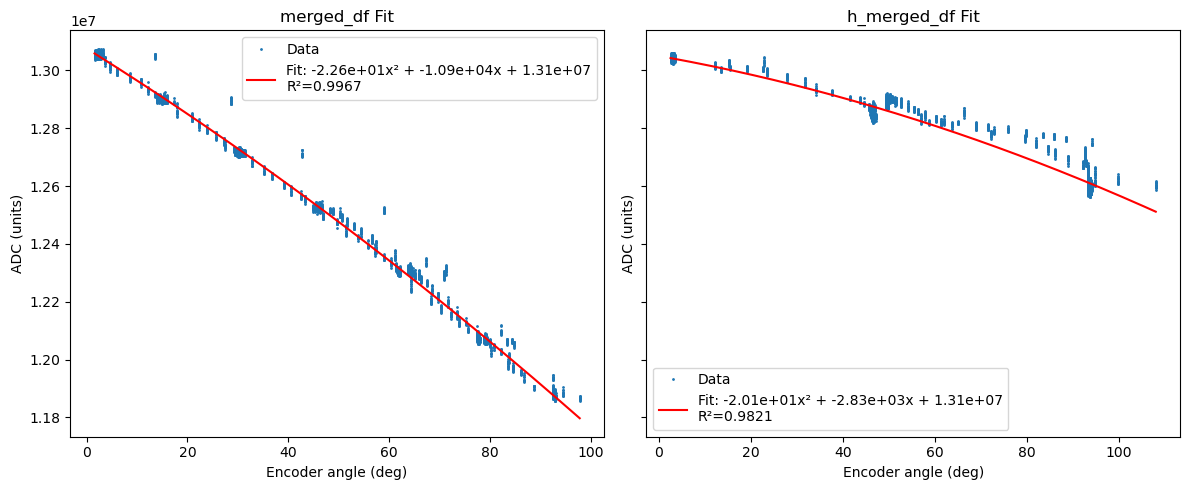

In [47]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd

# Quadratic model
def quad_model(x, a, b, c):
    return a*x**2 + b*x + c

def fit_and_plot(ax, df, title):
    # Clean data
    x = pd.to_numeric(-df["angle_renc"], errors="coerce")
    y = pd.to_numeric(df["adc_ch3"], errors="coerce")
    mask = x.notna() & y.notna()
    x = x[mask].to_numpy()
    y = y[mask].to_numpy()

    # Fit
    params, cov = curve_fit(quad_model, x, y)
    a, b, c = params

    # Predictions
    y_pred = quad_model(x, a, b, c)

    # R² calculation
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    # Smooth fit curve
    x_fit = np.linspace(x.min(), x.max(), 500)
    y_fit = quad_model(x_fit, a, b, c)

    # Plot
    ax.plot(x, y, ".", markersize=2, label="Data")
    ax.plot(x_fit, y_fit, "r-", 
            label=f"Fit: {a:.2e}x² + {b:.2e}x + {c:.2e}\nR²={r2:.4f}")
    ax.set_xlabel("Encoder angle (deg)")
    ax.set_ylabel("ADC (units)")
    ax.set_title(title)
    ax.legend()

# --- Side-by-side plots ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

fit_and_plot(axes[0], merged_df, "merged_df Fit")
fit_and_plot(axes[1], h_merged_df, "h_merged_df Fit")

plt.tight_layout()
plt.show()



In [48]:
import pandas as pd
import numpy as np

# --- Build the plotted-angle column (to match fit_and_plot sign) ---
ang = pd.to_numeric(h_merged_df["angle_renc"], errors="coerce")
x_plot = -ang  # match x = -df["angle_renc"] from your fit code

# --- Define bands (inclusive) ---
bands = {
    "near_0deg_0to1":   (0.0, 10),
    "near_45deg_44to46":(30, 60),
    "near_90deg_89to91":(70, 90),
}

# --- Slice each band into its own DataFrame ---
band_dfs = {}
for name, (lo, hi) in bands.items():
    mask = x_plot.notna() & (x_plot >= lo) & (x_plot <= hi)
    band_df = h_merged_df.loc[mask].copy()
    band_df["angle_for_plot_deg"] = x_plot[mask].values  # optional: keep the used angle
    band_df["band_label"] = name
    band_dfs[name] = band_df

# Access individually:
h0 = band_dfs["near_0deg_0to1"]
h45 = band_dfs["near_45deg_44to46"]
h90 = band_dfs["near_90deg_89to91"]

# Or combine for convenience:
h_bands_all = pd.concat([h0, h45, h90], ignore_index=True)

# Quick sanity check
print({k: len(v) for k, v in band_dfs.items()})


{'near_0deg_0to1': 4240, 'near_45deg_44to46': 5910, 'near_90deg_89to91': 195}


Global quadratic fit (all bands):
  a=13.769051680675087, b=-4593.5699855728635, c=13055478.896055428, R²=0.959066258970688


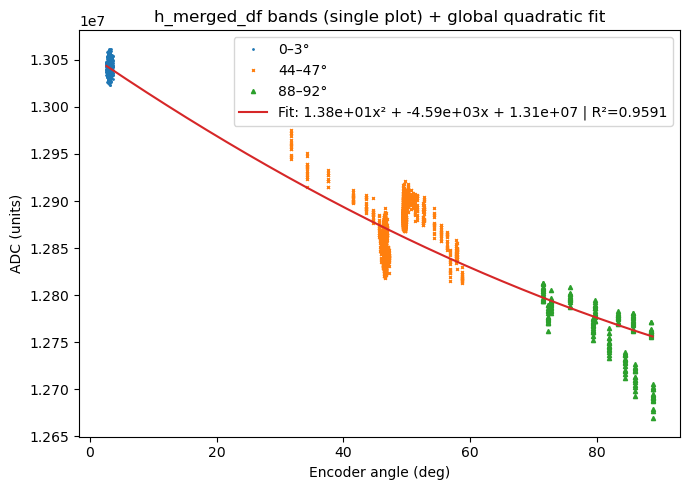

Saved figure: h_merged_df_bands_global_fit.png


In [49]:
# plotting data only close to 0, 45, and 90 degrees (or whereever three regions of data most consistent since hand moves)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Quadratic model ---
def quad_model(x, a, b, c):
    return a*x**2 + b*x + c

# --- Build combined X/Y from your band frames ---
# Assumes you've already created: h0, h45, h90, and h_bands_all
x_all = pd.to_numeric(h_bands_all["angle_for_plot_deg"], errors="coerce")
y_all = pd.to_numeric(h_bands_all["adc_ch3"], errors="coerce")
mask_all = x_all.notna() & y_all.notna()
x = x_all[mask_all].to_numpy()
y = y_all[mask_all].to_numpy()

# --- Plot: band points in one axes ---
fig, ax = plt.subplots(figsize=(7, 5))

# Plot each band with a distinct marker (keeps default colors)
ax.plot(pd.to_numeric(h0["angle_for_plot_deg"], errors="coerce"),
        pd.to_numeric(h0["adc_ch3"], errors="coerce"),
        ".", markersize=2, linestyle="None", label="0–3°")

ax.plot(pd.to_numeric(h45["angle_for_plot_deg"], errors="coerce"),
        pd.to_numeric(h45["adc_ch3"], errors="coerce"),
        "x", markersize=2, linestyle="None", label="44–47°")

ax.plot(pd.to_numeric(h90["angle_for_plot_deg"], errors="coerce"),
        pd.to_numeric(h90["adc_ch3"], errors="coerce"),
        "^", markersize=3, linestyle="None", label="88–92°")

ax.set_xlabel("Encoder angle (deg)")
ax.set_ylabel("ADC (units)")
ax.set_title("h_merged_df bands (single plot) + global quadratic fit")

# --- Fit one quadratic to ALL combined points ---
fit_text = "Fit failed"
try:
    # Need >=3 points to fit a quadratic
    if len(x) < 3:
        raise RuntimeError("Insufficient points for quadratic fit")

    params, cov = curve_fit(quad_model, x, y)
    a, b, c = params

    # Predictions + R²
    y_pred = quad_model(x, a, b, c)
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    # Smooth curve over observed range
    x_fit = np.linspace(x.min(), x.max(), 600)
    y_fit = quad_model(x_fit, a, b, c)

    fit_text = f"Fit: {a:.2e}x² + {b:.2e}x + {c:.2e} | R²={r2:.4f}"
    ax.plot(x_fit, y_fit, "-", label=fit_text)

    # Console summary
    print("Global quadratic fit (all bands):")
    print(f"  a={a}, b={b}, c={c}, R²={r2}")

except Exception as e:
    print(f"Global fit failed: {e}")

ax.legend(loc="best")
plt.tight_layout()

# Save to file (useful if inline JS isn’t available)
plt.savefig("h_merged_df_bands_global_fit.png", dpi=300)
plt.show()
print("Saved figure: h_merged_df_bands_global_fit.png")


In [50]:
h_bands_all

,timestamp,adc_ch0,adc_ch1,adc_ch2,adc_ch3,timestamp_renc,raw_renc,volts_renc,angle_renc,time_delta_renc,angle_for_plot_deg,band_label
0,121846342516,0,0,0,13038687,121846348692,14162,2.655375,-3.390454,6.176,3.390454,near_0deg_0to1
1,121846342516,0,0,0,13035956,121846348692,14162,2.655375,-3.390454,6.176,3.390454,near_0deg_0to1
2,121846342516,0,0,0,13039028,121846348692,14162,2.655375,-3.390454,6.176,3.390454,near_0deg_0to1
3,121846342516,0,0,0,13036127,121846348692,14162,2.655375,-3.390454,6.176,3.390454,near_0deg_0to1
4,121846342516,0,0,0,13034761,121846348692,14162,2.655375,-3.390454,6.176,3.390454,near_0deg_0to1
...,...,...,...,...,...,...,...,...,...,...,...,...
10340,121905264091,0,0,0,12791395,121905254608,8148,1.527750,-72.819650,-9.483,72.819650,near_90deg_89to91
10341,121905264091,0,0,0,12790371,121905254608,8148,1.527750,-72.819650,-9.483,72.819650,near_90deg_89to91
10342,121905264091,0,0,0,12793443,121905254608,8148,1.527750,-72.819650,-9.483,72.819650,near_90deg_89to91
10343,121905264091,0,0,0,12796515,121905254608,8148,1.527750,-72.819650,-9.483,72.819650,near_90deg_89to91


In [51]:
# sensor on autobender

g = bender_class()

# direct from aligned DataFrame
g.load_merged_df(merged_df, enc_col="angle_renc", adc_col="adc_ch3")

# Sensor on hand on autobender

h = bender_class()

# direct from aligned DataFrame
h.load_merged_df(h_bands_all, enc_col="angle_renc", adc_col="adc_ch3")




Loaded merged_df with 6505 rows into bender_class.
Loaded merged_df with 10345 rows into bender_class.


,Rotary Encoder,ADC Value,C3,C4
0,-3.390454,13038687,0,0
1,-3.390454,13035956,0,0
2,-3.390454,13039028,0,0
3,-3.390454,13036127,0,0
4,-3.390454,13034761,0,0
...,...,...,...,...
10340,-72.819650,12791395,0,0
10341,-72.819650,12790371,0,0
10342,-72.819650,12793443,0,0
10343,-72.819650,12796515,0,0


ADC normalized bw 0-1. ADC max:  1.0 ADC min:  0.0
ADC normalized bw 0-1. ADC max:  1.0 ADC min:  0.0


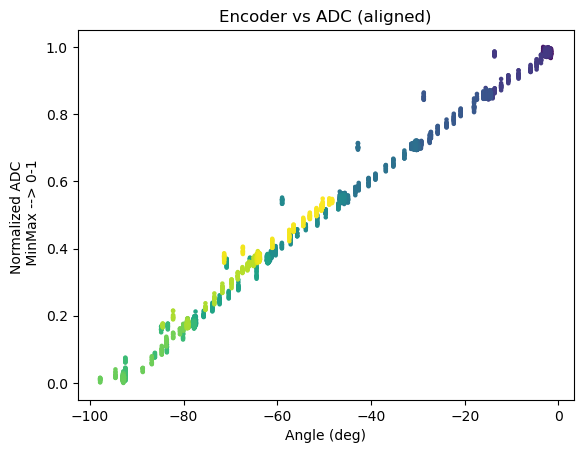

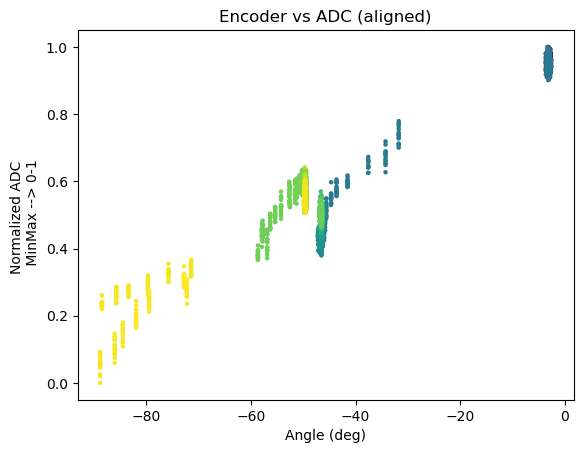

In [52]:
# sensor on autobnder
g.normalize_adc_bw_01()
g.plot_data(scatter=True, title="Encoder vs ADC (aligned)")

#sensor on hand on autobender

# now reuse existing methods
h.normalize_adc_bw_01()
h.plot_data(scatter=True, title="Encoder vs ADC (aligned)")



No angle threshold reaches 100% accuracy.
No angle threshold reaches 100% accuracy.
No angle threshold reaches 100% accuracy.


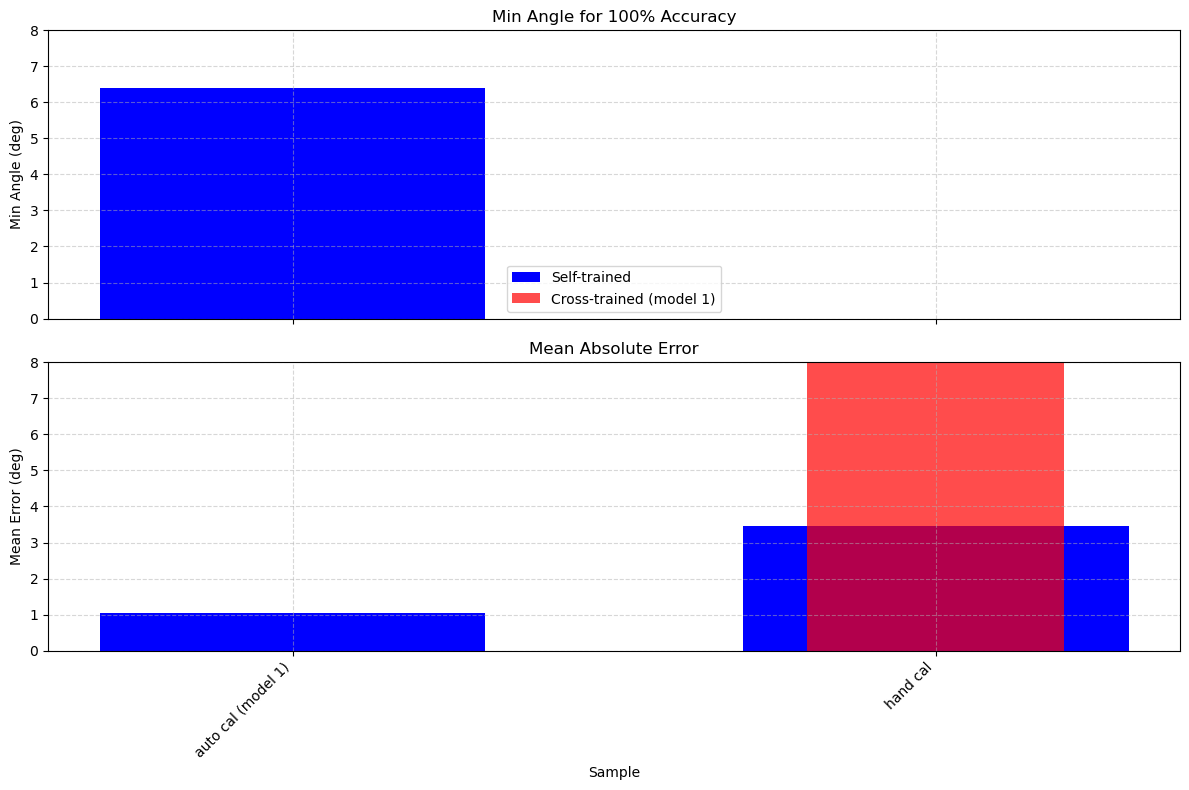

In [53]:
import re
import numpy as np
from sklearn.model_selection import train_test_split

# --- helpers to find your columns (works with 'angle_renc' or 'angle_renc_renc', etc.) ---
def pick_angle_col(df):
    cols = df.columns
    renc_candidates = [c for c in cols if re.search(r'angle.*_renc$', c)]
    if renc_candidates:
        return renc_candidates[0]
    for cand in ("angle_renc", "angle", "enc_angle"):
        if cand in cols: return cand
    raise KeyError(f"No encoder angle column found in: {list(cols)}")

def pick_adc_col(df):
    for cand in ("adc_ch3","adc_ch2","adc_ch1","adc_ch0","adc","ADC Value"):
        if cand in df.columns: return cand
    m = [c for c in df.columns if re.match(r'adc_ch\d+', c)]
    if m: return m[0]
    raise KeyError(f"No ADC column found in: {list(df.columns)}")

# --- adapter: build a bender_class from an already-normalized DataFrame ---
def bender_from_normalized_df(df,
                              enc_col=None,
                              adc_col=None,
                              invert_angle=False,
                              normalize_label="pre-normalized"):
    enc_col = enc_col or pick_angle_col(df)
    adc_col = adc_col or pick_adc_col(df)

    # Build the 2 columns bender_class expects
    enc = np.asarray(df[enc_col], dtype=float)
    if invert_angle:
        enc = -enc
    adc = np.asarray(df[adc_col], dtype=float)

    # Create instance and inject data directly
    m = bender_class()
    m.data = pd.DataFrame({
        "Rotary Encoder": enc,    # degrees
        "ADC Value":      adc     # already normalized to your liking
    })
    m.columns = m.data.columns
    m.adc_normalized = True              # <- critical
    m.normalize_type = normalize_label   # purely for axis label/legend
    return m

# ---------------------------------------
# YOUR EXISTING STRUCTURE (no load/normalize)
# ---------------------------------------
# Inputs:
DS_all = [[merged_df], [h_bands_all]]
bar_labels = ["auto cal", "hand cal"]
degree = 15 

# Flatten datasets + labels
DS_flat = []; xlabel_flat = []
for ds_group, ds_lab in zip(DS_all, bar_labels):
    xlabel_flat.extend([ds_lab]*len(ds_group))
    DS_flat.extend(ds_group)

pairwise_min_accuracy = np.full((len(DS_flat), len(DS_flat)), np.nan)
pairwise_abs_error    = np.full((len(DS_flat), len(DS_flat)), np.nan)

for i, train_df in enumerate(DS_flat):
    train_name = f"DS{i+1}"

    # Build model directly from the pre-normalized DataFrame
    g = bender_from_normalized_df(train_df, normalize_label="pre-normalized (user)")
    # High-capacity fit on ~all train data (same as your old perc_train=0.99, niter=1)
    g.train_model_test_accuracy(perc_train=0.99, niter=1, degree=degree)

    for j, test_df in enumerate(DS_flat):
        if i == j:
            # Diagonal: within-sample CV with separate instance
            g2 = bender_from_normalized_df(train_df, normalize_label="pre-normalized (user)")
            # Your original used degree=2 here; keep that if intended:
            g2.train_model_test_accuracy(perc_train=0.8, niter=10, degree=2)

            min_angle_100, all_min_angle_100 = g.get_min_accuracy_100()
            if all_min_angle_100:
                pairwise_min_accuracy[i, j] = float(np.mean(np.array(all_min_angle_100)))
            if hasattr(g2, "abs_angular_error") and len(g2.abs_angular_error):
                pairwise_abs_error[i, j] = float(np.mean(np.hstack(g2.abs_angular_error)))
        else:
            # Off-diagonal: predict on held-out slices from the OTHER dataset
            g_test = bender_from_normalized_df(test_df, normalize_label="pre-normalized (user)")
            df_test = g_test.data

            acc_runs, err_runs = [], []
            for seed in range(10):
                _, df_te = train_test_split(df_test, test_size=0.2, shuffle=True, random_state=seed)
                accuracy, abs_error = g.predict_new_data(df_te)
                acc_runs.append(accuracy)
                err_runs.append(abs_error)

            if acc_runs:
                acc_mat = np.vstack(acc_runs)
                min_angle_100, all_min_angle_100 = g.get_min_accuracy_100(accuracy_matrix=acc_mat) or (np.nan, None)
                if all_min_angle_100:
                    pairwise_min_accuracy[i, j] = float(np.mean(np.array(all_min_angle_100)))
            if err_runs:
                pairwise_abs_error[i, j] = float(np.mean(np.hstack(err_runs)))

# ---------------------------------------------------
# PLOT using your class method (any instance works)
# ---------------------------------------------------
m = bender_class()
m.plot_compact_pairwise_comparison(
    pairwise_min_accuracy,
    pairwise_abs_error,
    xlabel_flat,
    group_size=2,   # 2 datasets
    ylim=(0, 8)
)


##  Master Plotting Attempt, combine autobender raw data with hand cal adjusted (where three angles worth of data selected), re do norm plot and error calc where new model on both data is used to predict just the hand cal data.  

Loaded merged_df with 6505 rows into bender_class.
ADC normalized bw 0-1. ADC max:  1.0 ADC min:  0.0
Estimated radius r ≈ 0.4049 in  (95% CI: 0.4007, 0.4091),  R²=0.9944


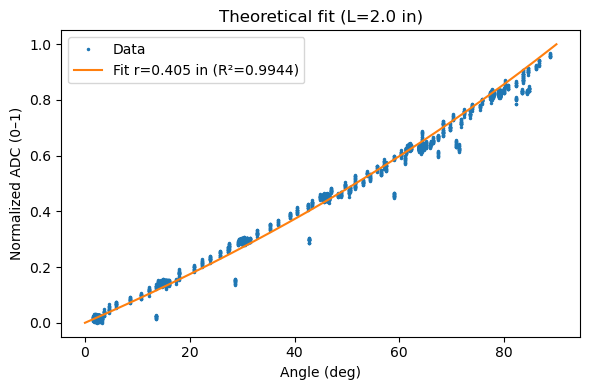

In [55]:
g = bender_class()

# direct from aligned DataFrame
g.load_merged_df(merged_df, enc_col="angle_renc", adc_col="adc_ch3")
# now reuse existing methods
g.normalize_adc_bw_01()

res = g.fit_knuckle_radius_from_normalized(L=2.0, r0=0.5, plot=True, flip_data=True)
print(f"Estimated radius r ≈ {res['r_hat']:.4f} in  (95% CI: {res['r_ci95'][0]:.4f}, {res['r_ci95'][1]:.4f}),  R²={res['r2']:.4f}")


Loaded merged_df with 10345 rows into bender_class.
ADC normalized bw 0-1. ADC max:  1.0 ADC min:  0.0
Estimated radius r ≈ 0.2031 in  (95% CI: 0.1957, 0.2104),  R²=0.9460


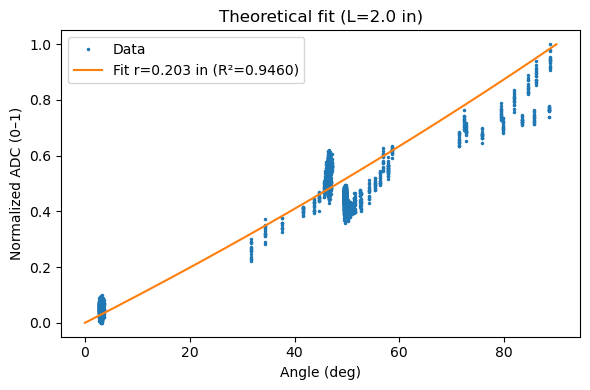

In [56]:
g = bender_class()

# direct from aligned DataFrame
g.load_merged_df(h_bands_all, enc_col="angle_renc", adc_col="adc_ch3")
# now reuse existing methods
g.normalize_adc_bw_01()

res = g.fit_knuckle_radius_from_normalized(L=2.0, r0=0.4, plot=True, flip_data=True)
print(f"Estimated radius r ≈ {res['r_hat']:.4f} in  (95% CI: {res['r_ci95'][0]:.4f}, {res['r_ci95'][1]:.4f}),  R²={res['r2']:.4f}")